<a href="https://colab.research.google.com/github/cedamusk/AI-N-ML/blob/main/Ordinal_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!pip install mord

In [69]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mord import LogisticIT
import warnings
warnings.filterwarnings('ignore')

In [70]:
def create_ordinal_dataset(n_samples=1000, n_features=5, n_classes=3, class_sep=2.0):
  X=np.random.randn(n_samples, n_features)
  beta=np.random.randn(n_features)
  z=np.dot(X, beta)
  z=z-np.mean(z)
  z=z*class_sep/np.std(z)

  thresholds=np.linspace(z.min(), z.max(), n_classes+1)[1:-1]
  y=np.zeros(n_samples, dtype=int)
  for i, threshold in enumerate(thresholds):
    y[z> threshold] =i+1

  return X, y

In [71]:
def custom_adjacency_scorer(y_true, y_pred):
  return np.mean(np.abs(y_true-y_pred) <= 1)

In [72]:
X, y=create_ordinal_dataset(
    n_samples=1000,
    n_features=5,
    n_classes=3,
    class_sep=2.0
)

In [73]:
pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),
    ('ordinal', LogisticIT())
])

In [74]:
param_grid={
    'ordinal__alpha': [0.001, 0.01, 0.1, 1.0]
}

In [75]:
X_train, X_test, y_train, y_test=train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [76]:
grid_search=GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'adjacency': make_scorer(custom_adjacency_scorer)
    },
    refit='adjacency',
    n_jobs=-1
)

In [77]:
grid_search.fit(X_train, y_train)
best_model=grid_search.best_estimator_

In [78]:
y_pred=best_model.predict(X_test)
y_pred_proba=best_model.predict_proba(X_test)

In [79]:
conf_matrix=confusion_matrix(y_test, y_pred)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred, average='weighted')
recall=recall_score(y_test, y_pred, average='weighted')
f1=f1_score(y_test, y_pred, average='weighted')

In [80]:
print("\nBest Model Parameters:")
print(grid_search.best_params_)


Best Model Parameters:
{'ordinal__alpha': 0.001}


In [81]:
print("\nCross-validation results:")
for metric, scores in grid_search.cv_results_.items():
  if metric.startswith('mean_test'):
    print(f"{metric}:{scores[grid_search.best_index_]:.4f}")


Cross-validation results:
mean_test_accuracy:0.7675
mean_test_adjacency:1.0000


In [82]:
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Model Evaluation Metrics:
Accuracy: 0.7500
Precision: 0.7387
Recall: 0.7500
F1 Score: 0.7277


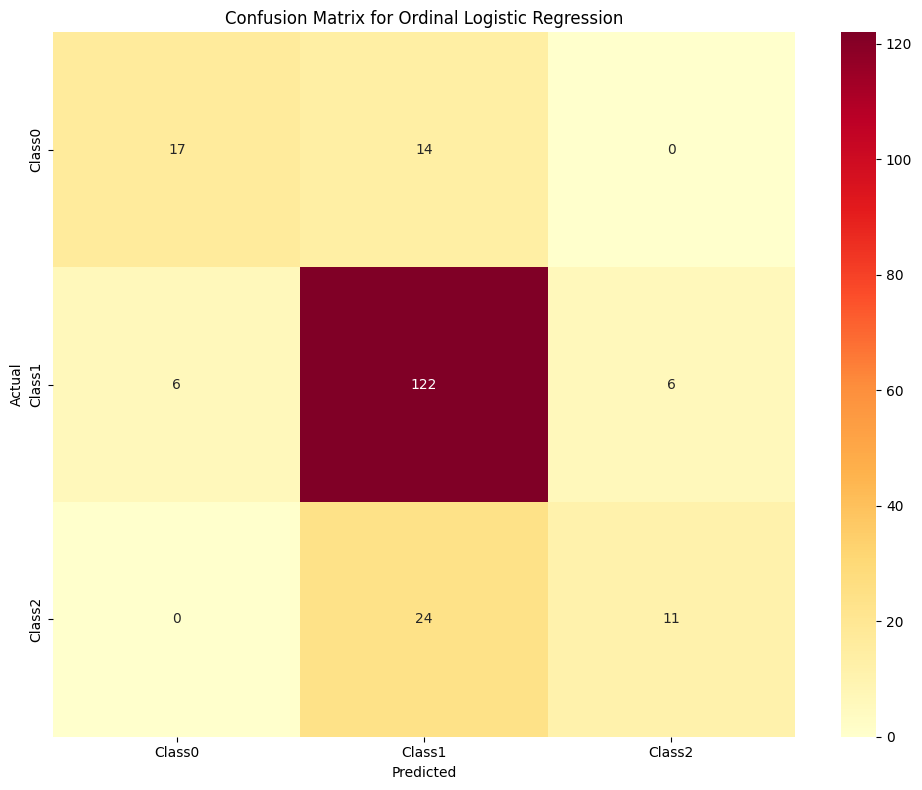

In [83]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=[f'Class{i}' for i in range(3)],
            yticklabels=[f'Class{i}' for i in range(3)])
plt.title('Confusion Matrix for Ordinal Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

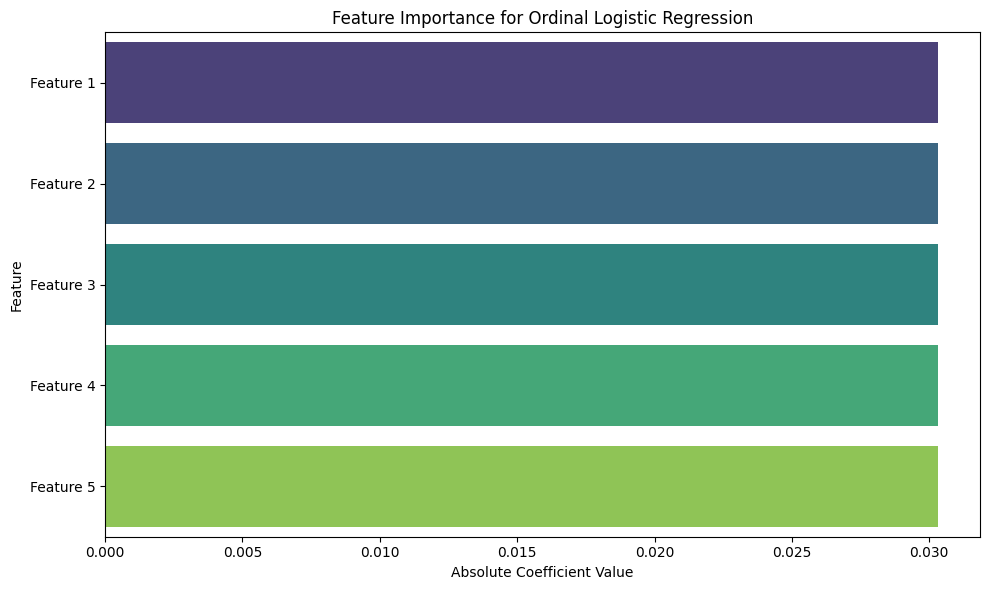

In [84]:
feature_importance=pd.DataFrame({
    'Feature':[f'Feature {i+1}' for i in range(5)],
    'Coefficient': np.abs(best_model.named_steps['ordinal'].coef_[0])
})
feature_importance=feature_importance.sort_values('Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance for Ordinal Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

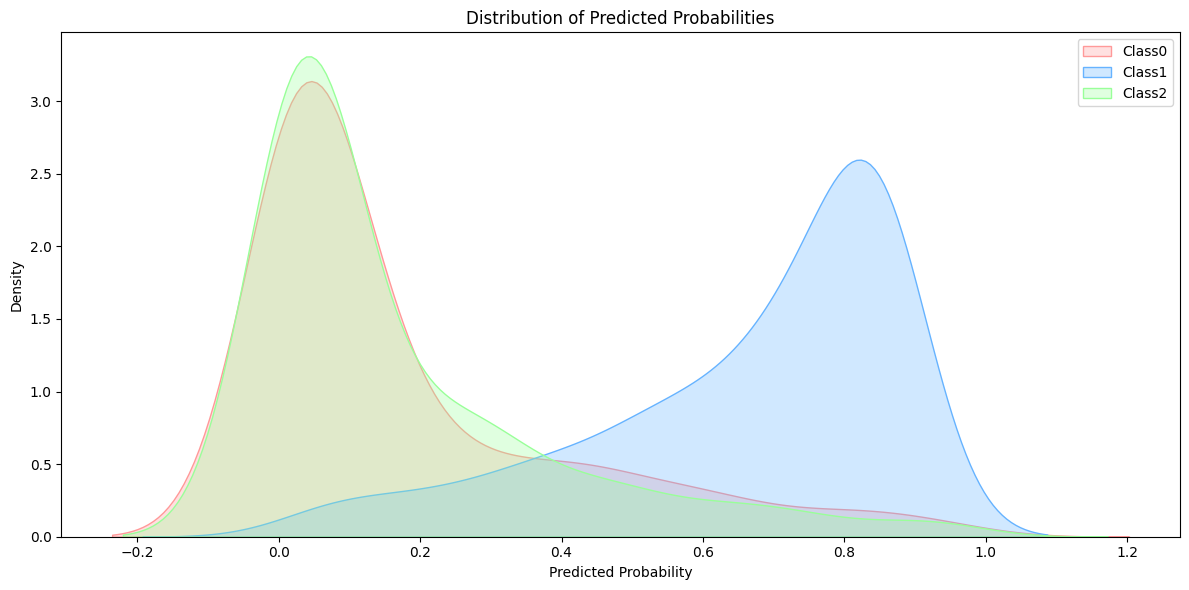

In [85]:
plt.figure(figsize=(12, 6))
colors=['#ff9999', '#66b3ff', '#99ff99']
for i in range(3):
  sns.kdeplot(y_pred_proba[:, i], label=f'Class{i}', color=colors[i], fill=True, alpha=0.3)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [86]:
print("\nClass-specific Metrics:")
for i in range(3):
  class_mask=y_test==i
  class_precision=precision_score(y_test==i, y_pred==i, zero_division=0)
  class_recall=recall_score(y_test==i, y_pred==i, labels=[i], zero_division=0)
  class_f1=f1_score(y_test==i, y_pred==i, zero_division=0)

  print(f"\nClass{i}:")
  print(f"\nClass in test set: {sum(class_mask)}")
  print(f"Precision: {class_precision:.4f}")
  print(f"Recall: {class_recall:.4f}")
  print(f"F1 Score: {class_f1:.4f}")


Class-specific Metrics:

Class0:

Class in test set: 31
Precision: 0.7391
Recall: 0.5484
F1 Score: 0.6296

Class1:

Class in test set: 134
Precision: 0.7625
Recall: 0.9104
F1 Score: 0.8299

Class2:

Class in test set: 35
Precision: 0.6471
Recall: 0.3143
F1 Score: 0.4231


In [87]:
adjacent_accuracy=np.mean(np.abs(y_test-y_pred)<=1)
print(f"\nadjacency Accuracy: {adjacent_accuracy:.4f}")


adjacency Accuracy: 1.0000


In [88]:
mae=np.mean(np.abs(y_test-y_pred))
mse=np.mean((y_test-y_pred)**2)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

Mean Absolute Error: 0.2500
Mean Squared Error: 0.2500


In [89]:
print("\nClass Distribution:")
print("Training Set:")
for i in range(3):
  print(f"Class {i}: {np.mean(y_train==i):.2f}")
print("\nTest set:")
for i in range(3):
  print(f"Class {i}: {np.mean(y_test==i):.2%}")


Class Distribution:
Training Set:
Class 0: 0.16
Class 1: 0.67
Class 2: 0.17

Test set:
Class 0: 15.50%
Class 1: 67.00%
Class 2: 17.50%
